In [146]:
# imports
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [147]:
train_dataset_url="subset-data/Training"
test_dataset_url="subset-data/Test"

In [148]:
# creating train and test folders
train_folder=os.listdir(train_dataset_url)
test_folder=os.listdir(test_dataset_url)

In [149]:
# checking the number of classes in train and test folder
print("Train Class: ", len(train_folder))
print("Test Class: ", len(test_folder))

Train Class:  3
Test Class:  3


In [150]:
# listing out names of each class of fruit present in train_folder
print(train_folder)

['Apple', 'Neither', 'Pear']


In [151]:
# listing out names of each class of fruit present in test_folder
print(test_folder)

['Apples', 'Neither', 'Pears']


In [152]:
#  importing libraries to change image into tensor dataset as pyTorch can't work on images
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [153]:
dataset = ImageFolder(train_dataset_url, transform=ToTensor())

In [154]:
# Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. 

img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 100, 100]) 0


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [155]:
print(dataset.classes)

['Apple', 'Neither', 'Pear']


In [156]:
import matplotlib.pyplot as plt

In [157]:
# Let's look at a couple of images from the dataset.

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Apple (0)


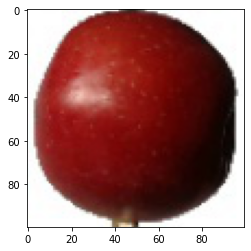

In [158]:
show_example(*dataset[0])

In [159]:
show_example(*dataset[2000])

IndexError: list index out of range

Label:  Apple (0)


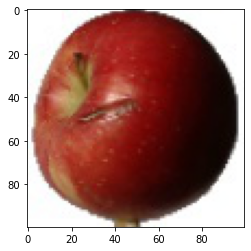

In [160]:
show_example(*dataset[200])

In [161]:
# Training and Validation Datasets:
# While building real world machine learning models, it is quite common to split the dataset into 3 parts:

# Training set - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
# Validation set - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
# Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model. 
# Since there's no predefined validation set, we can set aside a small portion of the training set to be used as the validation set. 
# We'll use the random_split helper method from PyTorch to do this. To ensure that we always create the same validation set.
# we'll also set a seed for the random number generator

# To ensure that we always create the same validation set, we'll also set a seed for the random number generator

random_seed = 42
torch.manual_seed(random_seed);

In [162]:
# let's print the lengths of train_ds and val_ds
val_size = 347
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1615, 347)

In [163]:
# We can now create data loaders for training and validation, to load the data in batches
from torch.utils.data.dataloader import DataLoader

batch_size=128 # The number of samples (data points) that would be passed through the network at a time.

In [164]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [165]:
# We can look at batches of images from the dataset using the make_grid method from torchvision. 
# Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

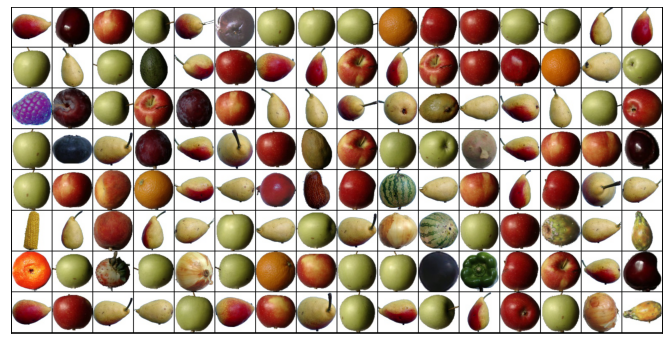

In [166]:
# let's view the grid of batches of images
show_batch(train_dl)

In [167]:
# As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time.
# GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time
# This makes GPU(s) ideal for training deep neural networks with many layers.

# We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using torch.cuda.is_available.
torch.cuda.is_available()

True

In [168]:
# Let's define a helper function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# Next, let's define a function that can move data and model to a chosen device.

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move data to the selected device, as a batches are accessed. 
# All we need is an __iter__ method to retrieve batches of data, and an __len__ method to get the number of batches.

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [169]:
# let's check our type of device
device = get_default_device()
device

device(type='cuda')

In [170]:
import torch.nn as nn
import torch.nn.functional as F

In [171]:
# let's define our model

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        # . A commonly used loss function for classification problems is the cross entropy.
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [172]:
input_size=3*100*100 # parameters
output_size=3

In [173]:
# NOW LET'S UNDERSTAND FEEDFORWARD NEURAL NETWORKS 
# Feedforward neural networks were among the first and most successful learning algorithms.
# They are also called deep networks, multi-layer perceptron (MLP), or simply neural networks. 
# As data travels through the network’s artificial mesh, each layer processes an aspect of the data, filters outliers, spots familiar entities and pro
# NOW LET'S UNDERSTAND LAYERS OF FEEDFORWARD NEURAL NETWORKS 
# Input layer: This layer consists of the neurons that receive inputs and pass them on to the other layers. 
# The number of neurons in the input layer should be equal to the attributes or features in the dataset.
# Output layer: The output layer is the predicted feature and depends on the type of model you’re building.
# Hidden layer: In between the input and output layer, there are hidden layers based on the type of model. 
# Hidden layers contain a vast number of neurons which apply transformations to the inputs before passing them. 
# As the network is trained, the weights are updated to be more predictive. 
# Introducing a hidden layer and an activation function allows the model to learn more complex, multi-layered and non-linear relationships between the 

In [174]:
class FruitFnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(input_size, 2048) # hidden layer
        self.linear2=nn.Linear(2048, 1024) # hidden layer
        self.linear3=nn.Linear(1024, 512)  # hidden layer
        self.linear4=nn.Linear(512, 64) #hidden layer
        self.linear5=nn.Linear(64, output_size) # output layer
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        # Get predictions using output layer
        return out

In [175]:
# TRAINING THE MODEL

# for epoch in range(num_epochs):
    # Training phase
    # for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
   #  for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
    
@torch.no_grad()

# Here we are using torch.max() function, this function's default behaviour as you can guess by the name is to return maximum among the elements in the Tensor. 
# However, this function also helps get the maximum along a particular dimension, as a Tensor, instead of a single element.
# To specify the dimension (axis – in numpy), there is another optional keyword argument, called dim. This represents the direction that we take for the maximum.
# dim=0, (maximum along columns).
# dim=1 (maximum along rows).

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch) # extract loss
            train_losses.append(loss)
            loss.backward() # generate gradients
            optimizer.step() # All optimizers implement a step() method, that updates the parameters.
            optimizer.zero_grad() # Clears the gradients of all optimized torch.Tensor,because every time a variable is back propogated through,
            
            # the gradient will be accumulated instead of being replaced.
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item() # combine losses
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    


In [176]:
# We have defined an accuracy function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a met

In [177]:
# Building Feed-Forward neural networks
Fnn_model = FruitFnnModel()
Fnn_model

FruitFnnModel(
  (linear1): Linear(in_features=30000, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=3, bias=True)
)

In [178]:
# Printing out the tensor data of Feed Forward Neural Networks

for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = Fnn_model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 100, 100])
out.shape: torch.Size([128, 1024])
out[0]: tensor([ 0.0627, -0.0398,  0.0196,  ...,  0.1429,  0.0875, -0.2320],
       grad_fn=<SelectBackward0>)


In [186]:
# We can now wrap our data loaders using DeviceDataLoader.

Fnn_train_dl = DeviceDataLoader(train_dl, device)
Fnn_val_dl = DeviceDataLoader(val_dl, device)
to_device(Fnn_model, device);

In [187]:
# Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). 
# We can reuse the to_device function to move the model's parameters to the right device.
Fnn_model = to_device(FruitFnnModel(), device)

In [188]:
# Let's see how the model performs on the validation set with the initial set of weights and biases.
evaluate(Fnn_model, Fnn_val_dl)

{'val_loss': 6.890811920166016, 'val_acc': 0.0}

In [189]:
num_epochs = 4 # An epoch is one single pass of all the input data through the network.

# torch.optim is a package implementing various optimization algorithms
opt_func = torch.optim.Adam

# The amount of change to the model during each step of this search process, or the step size, is called the “learning rate” .
# It is the most important hyperparameter to tune for your neural network in order to achieve good performance on your problem.
# Learning rate controls how quickly or slowly a neural network model learns a problem.
lr = 0.001

In [190]:
# We are now ready to train the model. Let's train for 4 epochs and look at the results. 
Fnn_history = fit(num_epochs, lr, Fnn_model, Fnn_train_dl, Fnn_val_dl, opt_func)

Epoch [0], train_loss: 13.6633, val_loss: 5.2429, val_acc: 0.6021
Epoch [1], train_loss: 3.6033, val_loss: 1.4395, val_acc: 0.8975
Epoch [2], train_loss: 1.1855, val_loss: 0.6918, val_acc: 0.9374
Epoch [3], train_loss: 0.9420, val_loss: 0.5091, val_acc: 0.9390


In [191]:
# While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. 
# This is easier to see using a line graph.

In [192]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('accuracy vs. number of epochs');

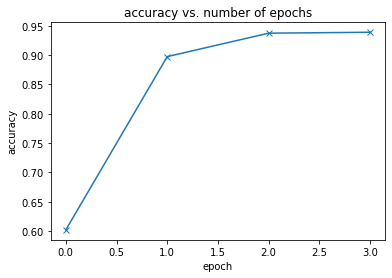

In [193]:
plot_accuracies(Fnn_history)

In [194]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs : ');

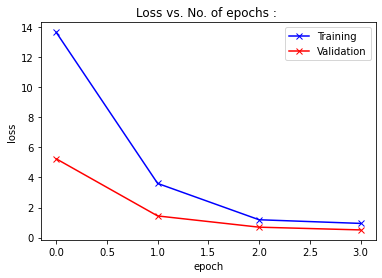

In [195]:
plot_losses(Fnn_history)

In [196]:
# let's check our model's loss and accuracy last time.
evaluate(Fnn_model, Fnn_val_dl)

{'val_loss': 0.5090514421463013, 'val_acc': 0.9389594793319702}

In [197]:
test_dataset = ImageFolder(test_dataset_url, transform=ToTensor())
len(test_dataset)

347

In [198]:
# NOW LET'S TEST OUR MODEL FOR INDIVIDUAL IMAGES.

In [199]:
# While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. 

In [200]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: Neither , Predicted: Pear


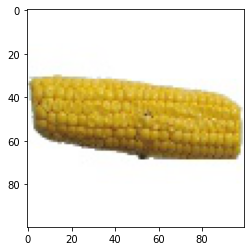

In [208]:
img, label = test_dataset[187]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, Fnn_model))

Label: Apple Crimson Snow , Predicted: Apple Crimson Snow


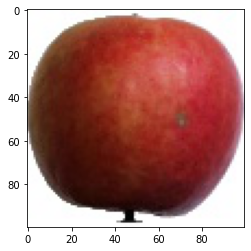

In [70]:
img, label = test_dataset[200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, Fnn_model))

Label: Pear Kaiser , Predicted: Pear Stone


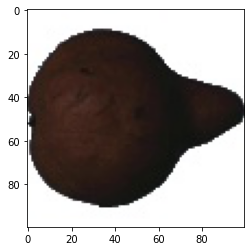

In [71]:
img, label = test_dataset[3000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, Fnn_model))

Label: Apple Red Yellow 2 , Predicted: Apple Red Yellow 2


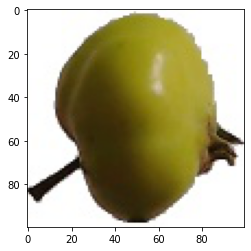

In [72]:
img, label = test_dataset[2100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, Fnn_model))

Label: Pear , Predicted: Pear


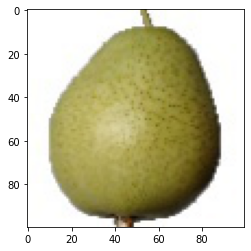

In [73]:
img, label = test_dataset[2200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, Fnn_model))